In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

from src.models.prompt_vit import PromptTunedViT


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = PromptTunedViT(num_classes=2)
model.load_state_dict(torch.load("../experiments/checkpoints/prompt_vit_real.pt", map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully on", device)


✅ Model loaded successfully on cpu


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_path = "../data/val/polyp/download (2).jpg"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)
print("🖼️ Image loaded:", img_path)


🖼️ Image loaded: ../data/val/polyp/download (2).jpg


In [18]:
def generate_vit_gradcam(model, x):
    features = None

    def hook_fn(module, input, output):
        nonlocal features
        features = output[0]

    handle = model.base_model.blocks[-1].register_forward_hook(hook_fn)

    outputs = model(x)
    pred_class = outputs.argmax(dim=1).item()

    model.zero_grad()
    one_hot = torch.zeros_like(outputs)
    one_hot[0, pred_class] = 1
    outputs.backward(gradient=one_hot, retain_graph=True)

    cams = features.mean(dim=-1).squeeze().detach().cpu().numpy()  # (N,)

    num_tokens = cams.shape[0]
    num_prompt = model.prompt.shape[1] if hasattr(model, "prompt") else 0

    patch_cams = cams[(1 + num_prompt):]

    side = int(np.sqrt(patch_cams.shape[0]))
    cam = patch_cams.reshape(side, side)

    cam = np.maximum(cam, 0)
    if cam.max() != 0:
        cam = cam / cam.max()
    else:
        cam = np.zeros_like(cam)

    handle.remove()
    return cam, pred_class


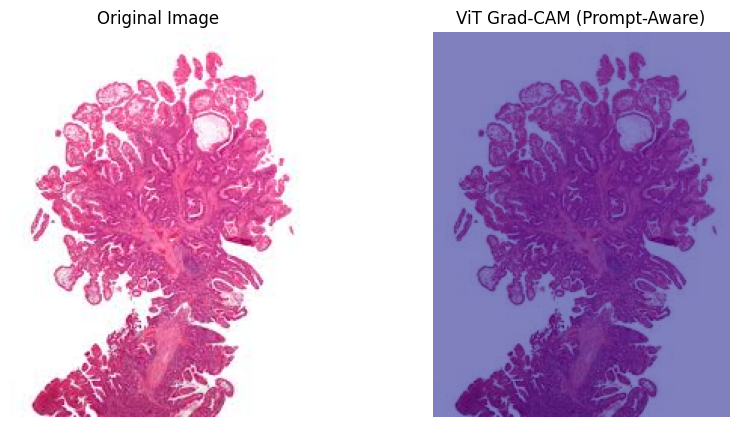

Predicted Class: 1 (0=Non-Polyp, 1=Polyp)


In [19]:
cam, pred_class = generate_vit_gradcam(model, input_tensor)

cam_img = np.uint8(255 * cam)
cam_img = Image.fromarray(cam_img).resize(image.size, Image.BILINEAR)
cam_img = np.array(cam_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("ViT Grad-CAM (Prompt-Aware)")
plt.imshow(image)
plt.imshow(cam_img, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

print(f"Predicted Class: {pred_class} (0=Non-Polyp, 1=Polyp)")